<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# K-medoides. Fundamentos Teóricos.

Este *cuaderno* trata sobre K-medoides como método de clustering.  El objetivo del *cuaderno* es que usted aprenda sobre el método de K-medoides y el algoritmo PAM que es el más utilizado para aplicarlo. Se busca también que sea capaz de reconocer las características y el funcionamiento de este algoritmo, y cómo implementarlo.


**NO** es necesario editar el archivo o hacer una entrega. Sin embargo, los ejemplos contienen celdas con código ejecutable (`en gris`), que podrá modificar  libremente. Esta puede ser una buena forma de aprender nuevas funcionalidades del *cuaderno*, o experimentar variaciones en los códigos de ejemplo.

## Introducción

En el *cuaderno Clustering: K-medias. Fundamentos Teóricos.* vimos que este es generalmente un buen algoritmo, pero que posee dos limitaciones: (i) la métrica es Euclidiana y  (ii) no es robusto a la presencia de *outliers* o valores atípicos. En este *cuaderno* estudiaremos el método de K-medoides como solución a estas limitaciones.

K-medoides es un método de clustering muy similar a K-medias puesto que ambos agrupan las observaciones en K clusters. Sin embargo, la diferencia principal radica en que K-medoides en vez de utilizar centroides, emplea medoides. Un medoide es un elemento del cluster cuya distancia promedio entre él y todos los demás elementos del cluster es la menor posible. Este elemento es el elemento más central del cluster y por lo tanto podemos considerarlo como el más representativo. 

El hecho de utilizar medoides en lugar de centroides hace de K-medoides un método más robusto que K-medias, ya que es menos sensible a *outliers* o valores atípicos. La siguiente figura ilustra la diferencia y muestra como la presencia de un *outlier* posiciona al centroide, denotado con $x$, fuera de la región más densa:


<center>
<img src = "figs/media_vs_medoide.png" alt="centroides">
</center>



Notemos además que para la figura de la izquierda, el punto central, la media, no es una observación del cluster y este centro se ve influenciado por la presencia de un *outlier*. En la figura de la derecha, el medoide, no sólo se ubica en la región más densa sino también que está representado por una de las observaciones del conjunto. Intuitivamente, este paralelismo se puede pensar como el que existe entre la media y mediana.

Antes de avanzar con los detalles de implementación, veamos un paso a paso sin códigos ni matemáticas de cómo se implementa este método:

 1. Comenzamos eligiendo un número $K$ de observaciones aleatorias que nos van a servir como  medoides iniciales. Esto nos dará como resultado $K$ clusters. 
 
 2. Calculamos la distancia entre las observaciones y los medoides.
 
 3. Con estas distancias asignamos cada observación a su medoide más cercano.
 
 4. Para cada uno de los $K$ clusters generados en el paso 3, corroboramos si el medoide elegido reduce la distancia promedio del cluster, si esto no ocurre, seleccionamos la observación que si lo hace.
 
 5. Si al menos un medoide cambió en el paso anterior, repetimos desde el paso 3, de caso contrario finalizamos.



## Implementación de K-medoides.

 El algoritmo más empleado para implementar el método de K-medoides se conoce como PAM (*Partitioning Around Medoids*) y  sigue los siguientes pasos: 

1. Para una asignación de clusters dada $C$, buscamos la observación central, medoide, $i^*_k$ en el cluster minimizando la distancia total a otros puntos en ese cluster:

$$i^*_k = argmin_{\{i: C(i) = k \}} \sum_{C(i') = k} D(x_i, x_i')$$

de esta forma, $i^*_k = x_{i^*_k}$ para $k = 1, \dots, K$ son los centros estimados de cada cluster.

2. Dado el conjunto actual de medoides del cluster $\{m_1,. . . , m_K\}$, minimizamos el error total asignando cada observación al medoide del cluster más cercano:

$$C(i) = argmin_{\{1 \leq k \leq K \}} D(x_i, m_k)$$

3. Iteramos los pasos 1 y 2 hasta que la asignación no cambie.


Inicialmente este algoritmo se implementó usando como medida de distancia ($D(x_i, m_k)$) la distancia de Manhattan, sin embargo el algoritmo puede ser generalizado para utilizar cualquier medida de distancia.

### K-medoides paso a paso en `Python`

Ilustremos entonces cómo implementaríamos K-medoides en `Phyton`. Para ello, generaremos datos que pertenecen a distintos clusters y fingiremos que desconocemos estos clusters. Luego, implementaremos K-medoides y veremos que tan buen trabajo hizo `Phyton`.

Comencemos entonces generando los datos usando la función `make_blobs` de la librería `Scikit-learn`. Crearemos 10 observaciones con 2 atributos que perteneces a 2 grupos. Para hacer replicable el ejercicio, elegiremos la semilla (`random_state`) `1234` (te invito a probar cambiando la semilla):


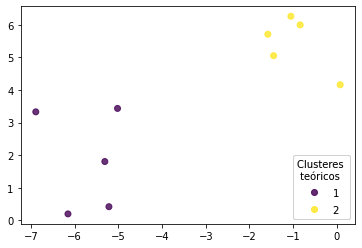

In [1]:
#Cargamos las librerías a utilizar
from sklearn.datasets import make_blobs

#Creamos los datos
X, y = make_blobs(n_samples = 10, n_features = 2, centers=2, random_state = 1234)


#Visualizamos los datos
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
g = plt.scatter(X[:,0], X[:,1], c = y + 1, alpha = 0.8)
legend = ax.legend(*g.legend_elements(), loc = "lower right", title = "Clusteres \n teóricos")
ax.add_artist(legend)
plt.show()

Este es un ejemplo relativamente sencillo que nos ayudará a comprender cómo funciona  K-medoides. Iniciamos asignando los datos aleatoriamente a $K$ clusters, en este caso usaremos 2. Te invito a que pruebes con un número distinto inicial, o que hagas la simulación más compleja. Para ello, podemos utilizar la función `random.randint` de `numpy` que devuelve enteros aleatorios, de forma tal por ejemplo que estamos asignando la primera y segunda observación al cluster 1, la tercera al 0, etc.:

In [2]:
import numpy as np

K=2
C = np.random.randint(0, K, size=(X.shape[0], ), dtype=np.int32)
C

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int32)

Luego generamos dos arrays donde vamos a guardar los medoides, su uso va a ser más claro en los siguientes pasos:

In [3]:
mu_idxs = np.zeros(shape=(K, X.shape[1]))
mu_copy = np.ones_like(mu_idxs)

Luego vamos a definir una medida de distancia a usar, en este caso elegí la distancia de Minkowski con $p=7$, pero te invito a que experimentes con distintas medidas. Definimos también la variable tolerancia que indica a la computadora que entendemos por "la asignación no cambie". En otras palabras, cuando la distancia entre los medoides encontrados en una iteración previa y la nueva es menor a la `tolerancia` podemos decir que la asignación no está cambiando.

In [4]:
metric = 'minkowski'
p = 7
tolerancia = 0.001

Finalmente, implementamos un bucle que realice los pasos anteriormente descriptos. Pero primero, debemos llamar ciertas funciones de las librerías [Scikit-learn](https://scikit-learn.org/stable/) o  [sciPy](https://scipy.org/).

El bucle entonces funciona de la siguiente forma, 
1. Mientras (`while`) la distancia entre los medoides del paso anterior (`mu_copy`) y el nuevo (`mu_idxs`), sea mayor a la tolerancia, continuamos en el bucle, de forma contraria, finaliza. Para que pueda iniciar el bucle, cuando creamos los arrays de `mu_idxs` y `mu_copy` lo hicimos con números superiores a la tolerancia.
2. Para cada uno de los $K$ clusters que asignamos, calculamos la distancia entre los puntos `Di` y los sumamos en `SDi` $\left(\sum_{C(i') = k} D(x_i, x_i')\right)$.
3. Luego encontramos el índice `idx` para el cual esta `SDi` es menor.
4. Asignamos esta observación como el nuevo medoide.
5. Dado este conjunto de medoides minimizamos `np.argmin` el error total asignando cada observación al medoide del cluster más cercano `C`.

El resultado es el array que indica el cluster al que fue asignada cada observación.

In [5]:
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics import adjusted_rand_score

while np.linalg.norm(mu_idxs - mu_copy) > tolerancia:
    for i in range(K):
        Di = squareform(pdist(X[C==i], metric=metric, p=p))
        SDi = np.sum(Di, axis=1)
        
        mu_copy[i] = mu_idxs[i].copy()
        idx = np.argmin(SDi)
        mu_idxs[i] = X[C==i][idx].copy()

    C = np.argmin(cdist(X, mu_idxs, metric=metric, p=p), axis=1)
C

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0])

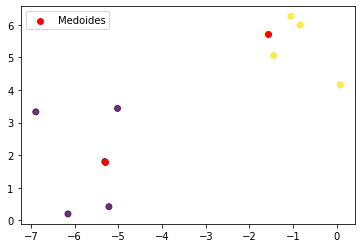

In [6]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
g = plt.scatter(X[:,0], X[:,1], c = C, alpha = 0.8)
g_centroides = plt.scatter(mu_idxs[:,0], mu_idxs[:,1], color = "red", label = "Medoides")
plt.legend([g_centroides], ["Medoides"], loc = "upper left")
plt.show()

La gráfica muestra que el algoritmo hizo un buen trabajo, y que en efecto los medoides son observaciones propias del conjunto de datos. Notemos la diferencia con $K-medias$, donde el centroide, en azul, no corresponde a ninguna observación del conjunto de los datos. También el efecto del *outlier* afecta al centroide en la parte superior derecha de la gráfica, mientras que el medoide no se ve afectado.

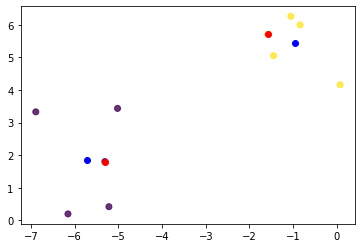

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state = 1234, n_init=10).fit(X)
centroides  = kmeans.cluster_centers_ 

fig, ax = plt.subplots()
g = plt.scatter(X[:,0], X[:,1], c = C, alpha = 0.8)
g_medoides = plt.scatter(mu_idxs[:,0], mu_idxs[:,1], color = "red", label = "Medoides")
g_centroides = plt.scatter(centroides[:,0], centroides[:,1], color = "blue", label = "Centroides")
plt.show()

#### K-medoides  con `sklearn`

En la práctica no es necesario escribir nuestra propia función, la librería `Scikit-learn` contiene una extensión [scikit-learn-extra](https://scikit-learn-extra.readthedocs.io/en/stable/index.html) que extiende la librería original y contiene una implementación de PAM: https://scikit-learn-extra.readthedocs.io/en/stable/modules/cluster.html. La ventaja del uso de esta librería es que los algoritmos son más eficientes y están optimizados; por lo que suelen correr más rápido y con menos errores. Su implementación es sencilla y entre sus parámetros se destacan:

    - `n_clusters`: determina el número $K$ de clusters que se van a generar.

    - `metric`: es la métrica que se desea utilizar

    - `init`: que especifica el método para iniciar los medoides.

     - `max_iter`: número máximo de iteraciones permitidas.

    - `random_state`: semilla para garantizar la reproducibilidad de los resultados.

Si bien tiene varios parámetros, estos tienen ciertos valores iniciales y podemos ejecutar la función simplemente especificando el número de clusters y de la semilla (usted puede modificar y experimentar qué sucede cuando se cambian los otros parámetros).

Para ilustrar la implementación utilicemos un ejemplo tomado directamente de Kaufman y Rousseeuw (1990). Los datos consisten en una matriz de disimilaridades obtenida a partir de un cuestionario a estudiantes de una clase de ciencias políticas. En el cuestionarios se les preguntó a los estudiantes sobre su valoración subjetiva de los coeficientes de disimilaridad entre 12 países: Bélgica (BEL), Brasil (BRA), Chile (CHI), Cuba (CUB), Egipto (EGY), Francia (FRA), India (IND), Israel (ISR), Estados Unidos (USA), Union Soviética (USS), Yugoslavia (YUG) y Zaire (ZAI). Los coeficientes finales de la matriz se obtuvieron tomando un promedio de los coeficientes proporcionados por los estudiantes.

In [8]:
import pandas as pd
# Cargamos y visualizamos los datos

df = pd.read_excel("data/diss_12_paises.xlsx", index_col = 0)
df

,BEL,BRA,CHI,CUB,EGY,FRA,IND,ISR,USA,USS,YUG,ZAI
BEL,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BRA,5.58,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHI,7.00,6.50,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUB,7.08,7.00,3.83,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EGY,4.83,5.08,8.17,5.83,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FRA,2.17,5.75,6.67,6.92,4.92,1.00,NaN,NaN,NaN,NaN,NaN,NaN
IND,6.42,5.00,5.58,6.00,4.67,6.42,1.00,NaN,NaN,NaN,NaN,NaN
ISR,3.42,5.50,6.42,6.42,5.00,3.92,6.17,1.00,NaN,NaN,NaN,NaN
USA,2.50,4.92,6.25,7.33,4.50,2.25,6.33,2.75,1.00,NaN,NaN,NaN
USS,6.08,6.67,4.25,2.67,6.00,6.17,6.17,6.92,6.17,1.00,NaN,NaN


Notemos que la datos vienen en una matriz diagonal con datos faltantes en la parte superior, entonces antes de proceder con nuestro análisis debemos completar estos faltantes con los valores correspondientes. Al ser una matriz simétrica necesitamos sólo copiar los valores de la parte inferior a la superior correspondiente.

In [9]:
import numpy as np
# Vamos a limpiar la matriz un poco
df_clean = df
df_clean = df_clean.fillna(0) + df_clean.T.fillna(0)
np.fill_diagonal(df_clean.values, 1)
df_clean

,BEL,BRA,CHI,CUB,EGY,FRA,IND,ISR,USA,USS,YUG,ZAI
BEL,1.00,5.58,7.00,7.08,4.83,2.17,6.42,3.42,2.50,6.08,5.25,4.75
BRA,5.58,1.00,6.50,7.00,5.08,5.75,5.00,5.50,4.92,6.67,6.83,3.00
CHI,7.00,6.50,1.00,3.83,8.17,6.67,5.58,6.42,6.25,4.25,4.50,6.08
CUB,7.08,7.00,3.83,1.00,5.83,6.92,6.00,6.42,7.33,2.67,3.75,6.67
EGY,4.83,5.08,8.17,5.83,1.00,4.92,4.67,5.00,4.50,6.00,5.75,5.00
FRA,2.17,5.75,6.67,6.92,4.92,1.00,6.42,3.92,2.25,6.17,5.42,5.58
IND,6.42,5.00,5.58,6.00,4.67,6.42,1.00,6.17,6.33,6.17,6.08,4.83
ISR,3.42,5.50,6.42,6.42,5.00,3.92,6.17,1.00,2.75,6.92,5.83,6.17
USA,2.50,4.92,6.25,7.33,4.50,2.25,6.33,2.75,1.00,6.17,6.67,5.67
USS,6.08,6.67,4.25,2.67,6.00,6.17,6.17,6.92,6.17,1.00,3.67,6.50


Al hacer esto tenemos que la disimilaridad entre Bélgica y Brasil es la misma que entre Brasil y Bélgica. Estamos entonces listos para aplicar la función `KMedoids` de [scikit-learn-extra](https://scikit-learn-extra.readthedocs.io/en/stable/index.html). Notemos que en este caso escogemos como métrica (`metric`): `precomputed` puesto que estamos usando ya una matriz de distancias y no es necesario entonces que la función las calcule.

Para comenzar iniciemos calculando un sólo cluster, para ver cuál es el medoide elegido:

In [10]:
from sklearn_extra.cluster import KMedoids 

Kmedoides = KMedoids(n_clusters = 1, metric = 'precomputed', random_state = 321).fit(df_clean)
Kmedoides.medoid_indices_


array([0])

El atributo `medoid_indices_` no da el índice de cuál es la observación elegida como medoide. En este caso es Bélgica. Un resultado interesante ya que con tantos países, el algoritmo elija como medoide de los datos a este país. Una explicación que proponen Kaufman y Rousseeuw (1990) es el hecho de que estos datos fueron propuestos por estudiantes belgas y estos tienden a percibir menores diferencias entre su propio país y otros, que entre países no propios.

Probemos ahora con 2 clusters:

In [11]:
Dos_medoides = KMedoids(n_clusters = 2, metric = 'precomputed', random_state = 1234).fit(df_clean)

# Veamos los resultados de los clusteres. 
list(zip(df_clean.columns, Dos_medoides.labels_))

[('BEL', 1),
 ('BRA', 1),
 ('CHI', 0),
 ('CUB', 0),
 ('EGY', 1),
 ('FRA', 1),
 ('IND', 0),
 ('ISR', 1),
 ('USA', 1),
 ('USS', 0),
 ('YUG', 0),
 ('ZAI', 1)]

Los resultados son bastante interesantes, el algoritmo agrupa a economías que tuvieron planificación centralizada en algún momento: China, Cuba, India, Unión Soviética y Yugoslavia, y las que no.

Finalmente, representemos gráficamente los resultados usando el método de escalado multidimensional (MDS). El escalado multidimensional es una representación gráfica de distancias o disimilaridades entre un conjunto de observaciones. Intuitivamente, los datos son escalados a dos dimensiones de forma tal que conserven las mismas propiedades. (Los detalles sobre MDS lo dejados para otro curso, pero te invito a leer más sobre el tema: https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

Para lograr el MDS utilizamos la función `MDS` y generamos una gráfica:

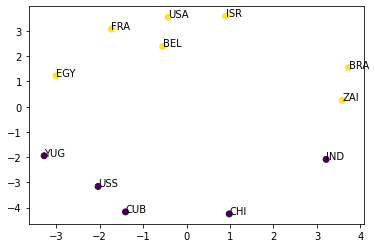

In [12]:
from sklearn.manifold import MDS

mds = MDS(n_components = 2, max_iter = 1000, dissimilarity = 'precomputed', random_state = 666)
resultado = mds.fit_transform(df_clean)
import matplotlib.pyplot as plt
plt.scatter(resultado[:,0], resultado[:,1], c = Dos_medoides.labels_)
n=df_clean.columns

for i, txt in enumerate(n):
    plt.annotate(txt, (resultado[i,0], resultado[i,1]))


La gráfica entonces muestra los resultados que encontramos anteriormente; el bloque de economías centralizadas en violeta y el bloque de economías descentralizadas en amarillo.

## Comparación entre K-Medias y K-Medoides 

Antes de finalizar este *cuaderno* comparemos el desempeño entre K-medias y K-medoides en dos conjunto de datos distintos: 

    (i) un conjunto donde los datos relativamente sencillo con clara separación de clusters y 
    (ii) datos más complejos.

Para el primer ejemplo vamos a crear datos ficticios con `make_blobs`. Estos datos van a tener 3 clusters subyacentes.

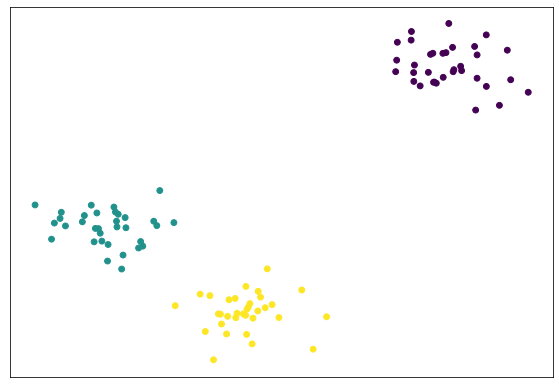

In [13]:
from sklearn import datasets

# Creamos los datos
n_observaciones = 100
X,y = datasets.make_blobs(n_samples = n_observaciones, centers = 3, cluster_std = 1, random_state = 1)

# Visualicemos los datos
fig, ax = plt.subplots(figsize = (10, 7), dpi = 70)
ax.scatter(x = X[:,0], y = X[:,1], c = y)
ax.set_xticks([]);
ax.set_yticks([]);

Aplicamos primero K-medias:

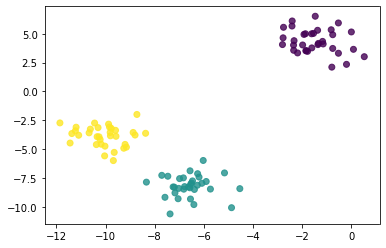

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 123, n_init=10).fit_predict(X)

fig, ax = plt.subplots()
g_puntos = plt.scatter(X[:,0], X[:,1], c = kmeans, alpha = 0.8)
plt.show()

Luego K-medoides

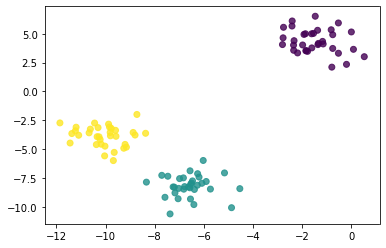

In [15]:
Kmedoides = KMedoids(n_clusters = 3, random_state = 123).fit(X)

fig, ax = plt.subplots()
g_puntos = plt.scatter(X[:,0], X[:,1], c = Kmedoides.labels_, alpha = 0.8)
plt.show()

Al comparar las gráficas vemos que ambos métodos dan los mismo resultados. La ausencia de valores atípicos o *outliers* hace que con ambos métodos obtengamos resultados muy similares. En estos casos se recomienda usar K-medias pues es más eficiente.

Sin embargo, analicemos ahora un caso donde tenemos un conjunto de datos más complejo. En este ejemplo vamos a usar una base que contiene las imágenes de números escritos a mano (https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html). Esta base está compuesta por 1,797 imagenes de 8x8 pixeles y los números se ven de la siguiente forma:

<center>

![Digits](https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png)

</center>

Las imágenes entonces están compuestas por píxeles y estos píxeles se pueden escribir como una matriz donde las entradas son las escalas de grises. 

In [16]:
# Cargamos los datos
from sklearn.datasets import load_digits
digits = load_digits()

Entonces el primer número será un array con 8x8=64 elementos

In [17]:
digits.data[1].shape

(64,)

Cada entrada los tonos de grises del pixel

In [18]:
digits.data[1]

array([ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
        9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
       15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
        0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
       16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.])

Si lo graficamos se verá de la siguiente forma:

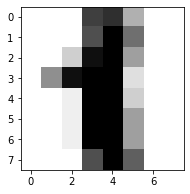

In [19]:
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

La tarea entonces es entonces agrupar estas 1,797 en 10 grupos. Cada grupo será correspondiente a cada uno de los números: 0,1,2,3,4,5,6,7,8 y 9.

Dada que la dimensión de cada uno de los dígitos es 64, vamos primero a reducir a 2 dimensiones. Para ello utilizaremos *PCA* (nótese que antes de aplicar esta técnica de reducción de dimensión reescalamos los datos; para más detalle te invito a revisar el *cuaderno: Análisis de Componentes Principales. Detalles sobre su Implementación*).

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data = scale(digits.data)
reduced_data = PCA(n_components = 2).fit_transform(data)
reduced_data 

array([[ 1.9142271 , -0.95455488],
       [ 0.58899598,  0.92463926],
       [ 1.30200907, -0.31720783],
       ...,
       [ 1.02266632, -0.14794174],
       [ 1.07609189, -0.38094321],
       [-1.25764004, -2.22761799]])

A continuación se ve el resultado de reducir a dos dimensiones los dígitos. La gráfica muestra por un lado que hay dígitos que claramente forman clusters, por ejemplo el 4 y 6, pero que también tienen outliers. Por otro lado, números como el 5 y el 9 aparecen solapados haciendo que potencialmente no sean fácilmente diferenciarlos entre sí. 

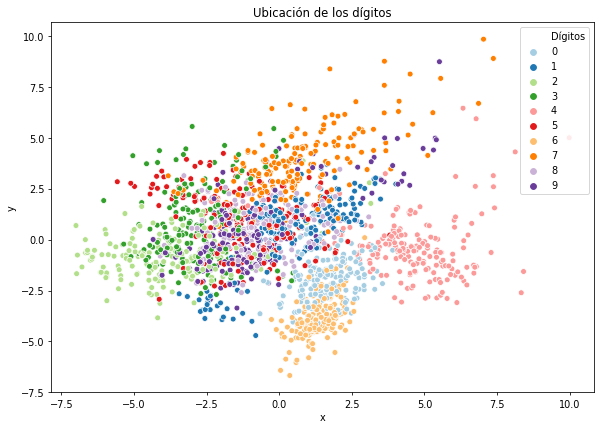

In [21]:
import seaborn as sns
# Creamos un df para visualizar los datos
digitos_plot = pd.DataFrame({"x": reduced_data[:,0], "y": reduced_data[:,1], 
    "Dígitos": digits.target})

# Visualizamos los datos
fig = plt.figure(figsize = (10, 7), dpi = 70)
plt.title("Ubicación de los dígitos")
ax = sns.scatterplot(x = digitos_plot["x"], y = digitos_plot["y"],
    hue = digitos_plot["Dígitos"], palette = "Paired")

Implementemos entonces K-medias y veamos su capacidad para separar los dígitos.

In [22]:
kmedias = KMeans(n_clusters = 10, random_state = 123, n_init=10).fit(reduced_data)

Luego de aplicar el algoritmo generamos una gráfica de los resultados. Para ello primero ponemos los datos en un `pandas data frame` y las predicciones en una variable llamada `y_pred`

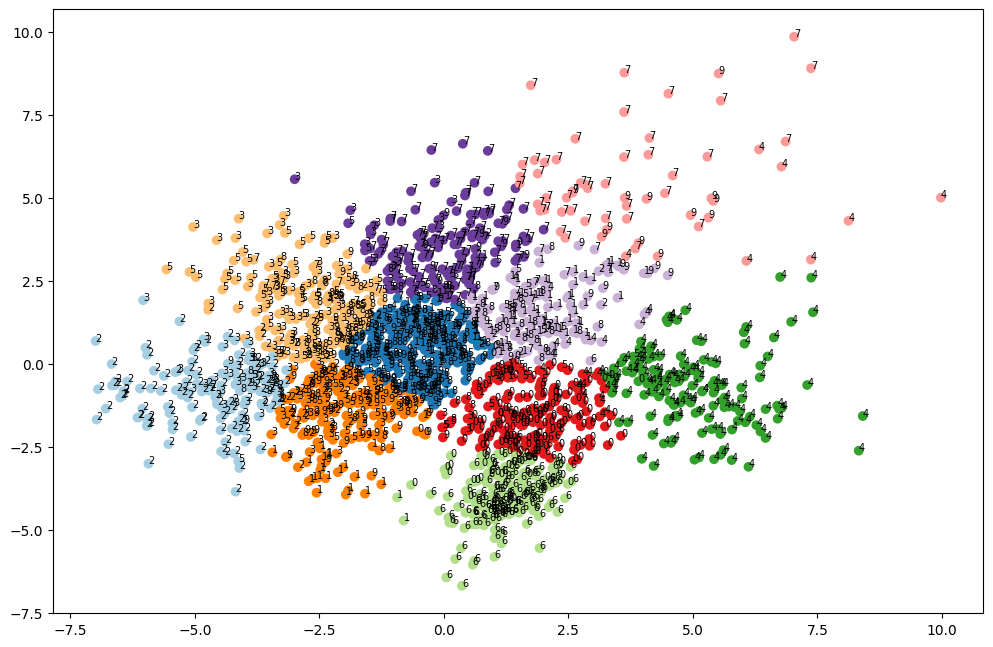

In [23]:
digitos_plot = pd.DataFrame({"X": reduced_data[:, 0], "Y": reduced_data[:, 1], "Dígito": digits.target}).reset_index(drop = True)

y_pred = kmedias.labels_.astype(int)
color = [sns.color_palette("Paired", 10)[k] for k in y_pred]

fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c = color)
for i, txt in enumerate(digitos_plot["Dígito"]):
       plt.text(digitos_plot["X"][i], digitos_plot["Y"][i], 
                digitos_plot["Dígito"][i], fontsize = 7)
plt.show()

Luego implementemos K-medoides y hacemos una gráfica similar de los resultados:

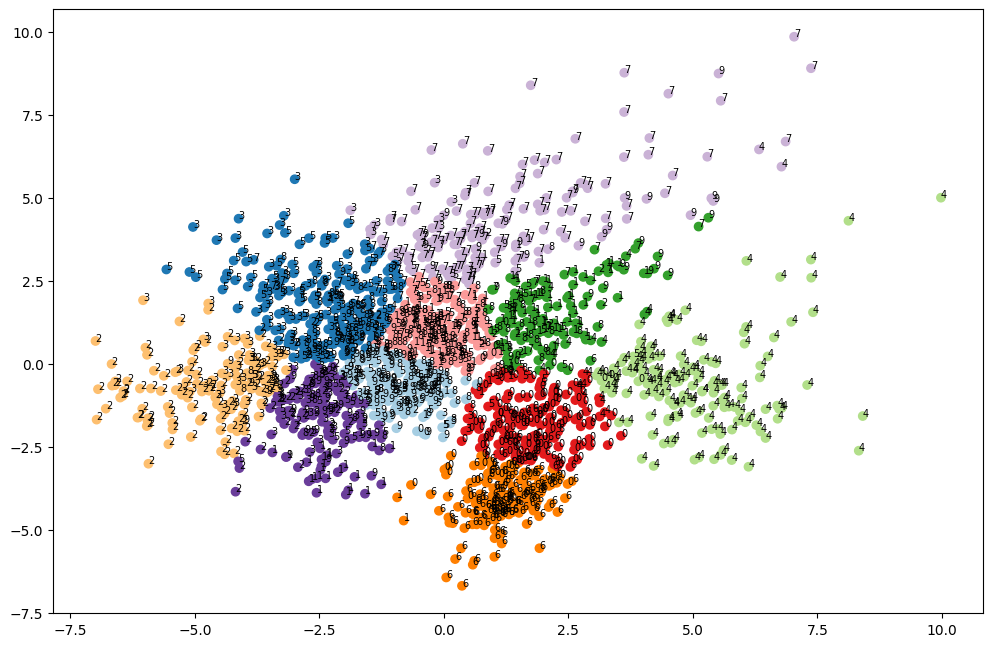

In [24]:
kmedoids = KMedoids(n_clusters = 10, random_state = 123).fit(reduced_data)

y_pred = kmedoids.labels_.astype(int)
color = [sns.color_palette("Paired", 10)[k] for k in y_pred]

fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c = color)
for i, txt in enumerate(digitos_plot["Dígito"]):
       plt.text(digitos_plot["X"][i], digitos_plot["Y"][i], 
                digitos_plot["Dígito"][i], fontsize = 7)
plt.show()

Las figuras anteriores muestran en colores los clusters predichos y sobre los puntos el verdadero número. Podemos comenzar comparando el desempeño de K-medias y K-medoides con los dígitos 0, 4 y 6, que formaban clusters relativamente claros. En este caso ambos algoritmos hacen un buen trabajo dada la clara separación inicial.  


No obstante existen ligeras diferencias en la agrupación de los puntos para ambos algoritmos. Por ejemplo, note que el dígito 4 está primordialmente concentrado en la esquina inferior derecha, pero que también tiene algunas entradas por encima de $7.5$ en el eje X y por encima de $2.0$ en el eje Y (esto lo podemos ver en la imagen anterior llamada "Ubicación de los dígitos" en el segmento de color rosado). Para este caso,  K-medias no clasifica correctamente los puntos más extremos, mientras que K-medoides es robusto a esos outliers. Del mismo modo, K-medias no separa correctamente los puntos correspondientes al dígito 7, los puntos atípicos que se expanden hacia arriba y a la derecha afectan su desempeño,  mientras que K-medoides si lo hace ya que es robusto a esos outliers y los reconoce dentro de la misma agrupación. En general, se puede apreciar que los clusters conformados por K-medoides son más alargados y permiten mayor varianza dentro de los datos que los clusters formados con K-medias.

Finalmente, cabe aclarar, que si bien estos algoritmos parecen funcionar bien y encuentran clusters claramente definidos, es importante ser cautos, reconocer la dificultad de la tarea y entender que los resultados pueden no ser tan claros o "limpios", especialmente con otros tipos de datos.


## Consideraciones finales

Antes de finalizar es importante reiterar que K-medoides es un método de clustering más robusto que K-medias, por lo que su performance será mejor en la presencia de valores atípicos u outliers. Sin embargo, esta robustez viene a cambio de un costo computacional mayor. Por ejemplo la complejidad de K-medoides es $O(N^2TK)$ donde $N$ es el número de observaciones, $T$ es el número de iteraciones y  $K$ es el número de clusters, mientras que la de K-medias es $O(NTK)$, considerablemente menor. Esto hace que K-medoides sea especialmente útil en muestras pequeñas. Sin embargo, en muestras grandes puede ser computacionalmente costoso, en estos casos podemos utilizar el método CLARA (Clustering For Large Applications, clustering para grandes aplicaciones). Este método, utiliza una técnica de muestreo y se implementa PAM para cada una de las muestras. El conjunto de medoides encontrados que da el mejor performance es el que se utiliza. (Los detalles de la implementación de CLARA están más allá de este curso, pero te invito a que investigues por tu cuenta)
 

# Referencias

- Amat Rodrigo, Joaquín (2022). Clustering y heatmaps: aprendizaje no supervisado. Available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/37_clustering_y_heatmaps. (Accedido 9 de Enero 2022) 

- Hastie, T., Friedman, J., &; Tisbshirani, R. (2017). The elements of Statistical Learning: Data Mining, Inference, and prediction. Springer. 

- Kaufman, L., &; Rousseeuw, P. J. (1990). Finding groups in data: An introduction to cluster analysis. Wiley. 

- Kaufman, L., & Rousseeuw, P. J. (1987). Clustering by means of Medoids. Statistical data analysis based on the L1–norm and related methods, edited by Y. Dodge.

- Patel, A. A. (2019). Hands-on unsupervised learning using Python: how to build applied machine learning solutions from unlabeled data. O'Reilly Media.

- Pedregosa, F. et al., 2011. Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825–2830.


# Información de Sesión

In [25]:
import session_info

session_info.show(html=False)

-----
matplotlib          3.5.3
numpy               1.18.4
pandas              1.0.3
scipy               1.4.1
seaborn             0.10.1
session_info        1.0.0
sklearn             1.0.2
sklearn_extra       0.3.0
-----
IPython             7.14.0
jupyter_client      6.1.3
jupyter_core        4.6.3
jupyterlab          2.1.1
notebook            6.0.3
-----
Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]
Linux-5.15.0-1017-aws-x86_64-with-debian-buster-sid
-----
Session information updated at 2023-08-18 12:53
